In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load and preprocess the Iris dataset
dataset = load_iris()
X = dataset.data  # Features (Sepal & Petal Length/Width)
y = dataset.target.reshape(-1, 1)  # Labels

# Normalize X using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

# Convert y to one-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(y)
y = torch.tensor(y, dtype=torch.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# B-Spline Activation Function using Cox-de Boor recursion
class BSplineActivation(nn.Module):
    def __init__(self, num_knots=11, degree=3):
        super(BSplineActivation, self).__init__()
        knots = np.linspace(-2.5, 3.2, num_knots)
        self.knots = torch.tensor(knots, dtype=torch.float32)
        self.degree = degree
        self.weights = nn.Parameter(torch.randn(num_knots - degree - 1))

    def forward(self, x):
        # global flag
        batch_size, input_dim = x.shape
        outputs = torch.zeros((batch_size, input_dim), device=x.device)
        
        for i in range(input_dim):
            basis_values = self.b_spline(x[:, i])

            # outputs[:, i] = torch.matmul(basis_values, self.weights)
            outputs[:, i] = basis_values @ self.weights

        return outputs


    def b_spline(self, x):
        n = len(self.knots) - 1
        B = torch.zeros((x.shape[0], n - self.degree), dtype=torch.float32, device=x.device)

        for j in range(n - self.degree):
            B[:, j] = self.bspline_basis(j, self.degree, x, self.knots)

        return B
    
    
    def bspline_basis(self, j, k, x, knots):
        if k == 0:
            return ((knots[j] <= x) & (x < knots[j + 1])).float()

        denom1 = knots[j + k] - knots[j]
        denom2 = knots[j + k + 1] - knots[j + 1]

        term1 = ((x - knots[j]) / denom1) * self.bspline_basis(j, k - 1, x, knots) if denom1 != 0 else 0
        term2 = ((knots[j + k + 1] - x) / denom2) * self.bspline_basis(j + 1, k - 1, x, knots) if denom2 != 0 else 0

        return term1 + term2





In [4]:
# Optimized KAN Model
class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_knots=11):
        super(KAN, self).__init__()
        self.hidden_layers = nn.ModuleList([BSplineActivation(num_knots) for _ in range(hidden_dim)])
        self.output_layer = nn.Linear(hidden_dim * input_dim, output_dim)


    def forward(self, x):
        h = torch.cat([layer(x) for layer in self.hidden_layers], dim=1)
        return self.output_layer(h)



In [5]:
# Training Function
def train_kan():
    model = KAN(input_dim=4, hidden_dim=5, output_dim=3)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    losses = []  # Store loss values for visualization

    for epoch in range(100):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Save loss value

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Evaluate Model
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred, y_test).item()
        accuracy = (y_test_pred.argmax(dim=1) == y_test.argmax(dim=1)).float().mean().item()
        print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy * 100:.2f}%")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot B-Spline basis functions
    x_vals = np.linspace(-2.5, 3.2, 100)
    print(x_vals.shape)
    plt.figure(figsize=(10, 6))
    for j in range(len(model.hidden_layers[0].knots) - model.hidden_layers[0].degree - 1):
        y_vals = np.array([model.hidden_layers[0].b_spline(torch.tensor([x], dtype=torch.float32)).cpu().numpy()[0, j] for x in x_vals])
        plt.plot(x_vals, y_vals, label=f'B[{j},{model.hidden_layers[0].degree}]')


    plt.title(f'B-Spline Basis Functions (Degree {model.hidden_layers[0].degree})')
    plt.xlabel('x')
    plt.ylabel('B-spline Basis')
    plt.legend()
    plt.grid()
    plt.show()



In [6]:
model = KAN(input_dim=4, hidden_dim=5, output_dim=3)

In [7]:
model

KAN(
  (hidden_layers): ModuleList(
    (0-4): 5 x BSplineActivation()
  )
  (output_layer): Linear(in_features=20, out_features=3, bias=True)
)

In [8]:
print(model.hidden_layers[0].weights)
print(model.hidden_layers[1].weights)
print(model.hidden_layers[2].weights)
print(model.hidden_layers[3].weights)
print(model.hidden_layers[4].weights)

Parameter containing:
tensor([ 0.0350,  0.6770, -0.4989, -0.3117, -0.6001,  0.8053,  0.0963],
       requires_grad=True)
Parameter containing:
tensor([-0.2275,  0.1446,  0.1234, -0.7049, -0.2256,  0.1321,  0.3946],
       requires_grad=True)
Parameter containing:
tensor([-0.0448,  1.8826,  0.3757,  1.0909,  1.1949,  0.7548,  0.0813],
       requires_grad=True)
Parameter containing:
tensor([-0.3412,  1.3437,  0.9601,  0.5465, -0.1432,  0.6608,  0.2942],
       requires_grad=True)
Parameter containing:
tensor([-0.2910, -1.9245, -0.7085, -0.5003, -1.2004,  0.0173, -0.7906],
       requires_grad=True)


In [9]:
X_train.shape

torch.Size([120, 4])

In [10]:
X.shape

torch.Size([150, 4])

In [11]:
X_test.shape

torch.Size([30, 4])

Epoch 0, Loss: 1.1606324911117554
Epoch 20, Loss: 0.47039738297462463
Epoch 40, Loss: 0.1742289960384369
Epoch 60, Loss: 0.1032530814409256
Epoch 80, Loss: 0.08205140382051468
Test Loss: 0.028080523014068604, Test Accuracy: 100.00%


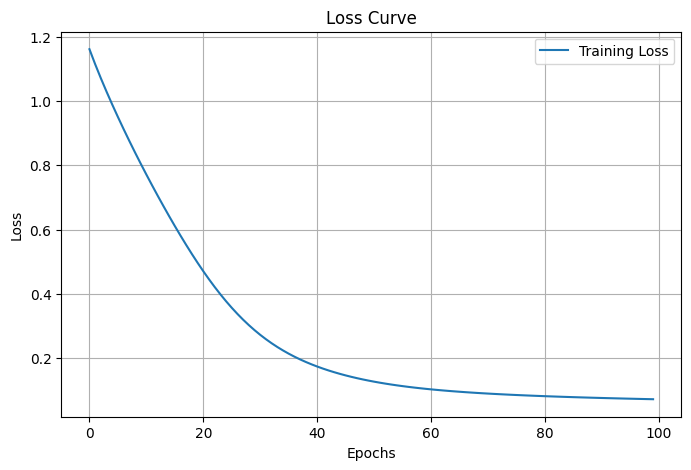

(100,)


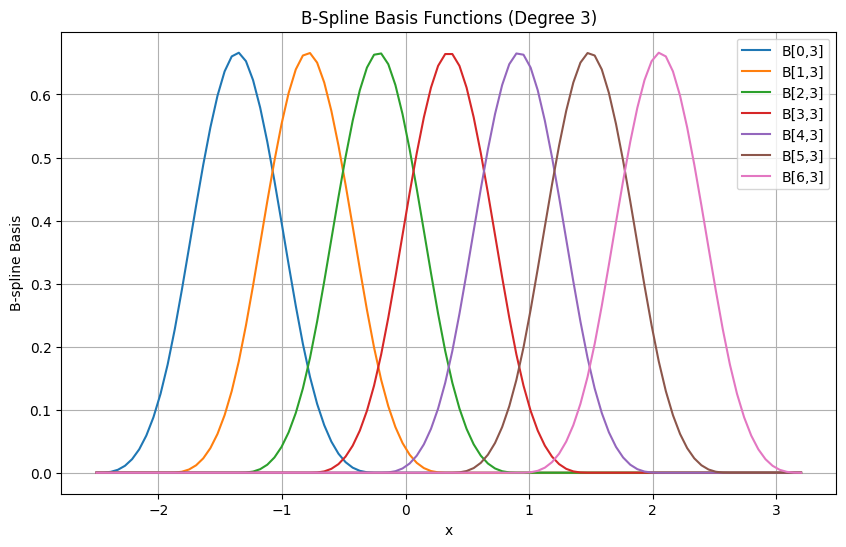

In [12]:
train_kan()